In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, concatenate, MaxPooling2D

from tensorflow.keras.metrics import AUC



In [46]:
def load_dataset(data_dir):
    images = []
    masks = []

    for image_file in os.listdir(os.path.join(data_dir, 'images')):
        if image_file.startswith("noncrack"):
            continue  # Skip images with no crack pixels

        image_path = os.path.join(data_dir, 'images', image_file)
        mask_path = os.path.join(data_dir, 'masks', image_file)
        
        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))
        cv2.imwrite(image_path, img)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (224, 224))
        cv2.imwrite(mask_path, mask)
        
        

        # image = cv2.imread(image_path)
        # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # image = cv2.resize(image, (224, 224))  # Updated size
        # mask = cv2.resize(mask, (224, 224))

        img = img / 255.0  # Normalize pixel values to be between 0 and 1
        mask = (mask / 255).astype(np.uint8)
        
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [47]:
def load_dataset_test(data_dir):
    images = []
    masks = []
    count = 0
    num = countImages("./crack_segmentation_dataset/train/images")
    
    for image_file in os.listdir(os.path.join(data_dir, 'images')):
        if(count == num):
            break
            
        if image_file.startswith("noncrack"):
            continue  # Skip images with no crack pixels

        image_path = os.path.join(data_dir, 'images', image_file)
        mask_path = os.path.join(data_dir, 'masks', image_file)
        
        img = cv2.imread(image_path)
        img = cv2.resize(img, (224, 224))
        cv2.imwrite(image_path, img)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (224, 224))
        cv2.imwrite(mask_path, mask)
        
        

        # image = cv2.imread(image_path)
        # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # image = cv2.resize(image, (224, 224))  # Updated size
        # mask = cv2.resize(mask, (224, 224))

        img = img / 255.0  # Normalize pixel values to be between 0 and 1
        mask = (mask / 255).astype(np.uint8)

        images.append(img)
        masks.append(mask)
        
        count += 1

    return np.array(images), np.array(masks)

def countImages(data_dir):
    count = 0
    for filename in os.listdir(data_dir):
        count += 1
    return count
    

In [3]:
# def data_generator(data_dir, batch_size=32):
#     batch_images = []
#     batch_masks = []

#     for image_file in os.listdir(os.path.join(data_dir, 'images')):
#         # Skip images with no crack pixels
#         if image_file.startswith("noncrack"):
#             continue 

#         # Only include images starting with "CFD" or "CRACK500"
#         if not image_file.startswith(("CFD", "CRACK500")):
#             continue

#         image_path = os.path.join(data_dir, 'images', image_file)
#         mask_path = os.path.join(data_dir, 'masks', image_file)

#         image = cv2.imread(image_path)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#         image = image / 255.0
#         mask = mask / 255.0

#         batch_images.append(image)
#         batch_masks.append(mask)

#         # Check if the batch is complete
#         if len(batch_images) == batch_size:
#             yield np.array(batch_images), np.array(batch_masks)
#             batch_images = []
#             batch_masks = []

In [48]:
def countImages(data_dir):
    count = 0
    for filename in os.listdir(data_dir):
        count += 1
    return count
    

In [49]:
num = countImages("./crack_segmentation_dataset/train/images")

In [50]:
data_dir = "./crack_segmentation_dataset/train"
#data_generator = data_generator(data_dir)

In [51]:
X, Y = load_dataset(data_dir)

In [52]:
X_test, Y_test = load_dataset_test("./crack_segmentation_dataset/test")

In [53]:
#X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X.dtype)
print(Y.dtype)
print(X_test.dtype)
print(Y_test.dtype)

float64
uint8
float64
uint8


In [11]:
# from __future__ import division
# import os,time,cv2
# import tensorflow as tf
# import tensorflow.contrib.slim as slim
# import numpy as np

# def conv_block(inputs, n_filters, filter_size=[3, 3], dropout_p=0.0):
# 	"""
# 	Basic conv block for Encoder-Decoder
# 	Apply successivly Convolution, BatchNormalization, ReLU nonlinearity
# 	Dropout (if dropout_p > 0) on the inputs
# 	"""
# 	conv = slim.conv2d(inputs, n_filters, filter_size, activation_fn=None, normalizer_fn=None)
# 	out = tf.nn.relu(slim.batch_norm(conv, fused=True))
# 	if dropout_p != 0.0:
# 	  out = slim.dropout(out, keep_prob=(1.0-dropout_p))
# 	return out

# def conv_transpose_block(inputs, n_filters, filter_size=[3, 3], dropout_p=0.0):
# 	"""
# 	Basic conv transpose block for Encoder-Decoder upsampling
# 	Apply successivly Transposed Convolution, BatchNormalization, ReLU nonlinearity
# 	Dropout (if dropout_p > 0) on the inputs
# 	"""
# 	conv = slim.conv2d_transpose(inputs, n_filters, kernel_size=[3, 3], stride=[2, 2])
# 	out = tf.nn.relu(slim.batch_norm(conv, fused=True))
# 	if dropout_p != 0.0:
# 	  out = slim.dropout(out, keep_prob=(1.0-dropout_p))
# 	return out

# def custom_model_light(inputs, num_classes, dropout_p=0.5, scope=None):
# 	"""
# 	Builds the Encoder-Decoder-Skip model. Inspired by SegNet with some modifications
# 	Includes skip connections

# 	Arguments:
# 	  inputs: the input tensor
# 	  n_classes: number of classes
# 	  dropout_p: dropout rate applied after each convolution (0. for not using)

# 	Returns:
# 	  Encoder-Decoder model
# 	"""

# 	#####################
# 	# Downsampling path #
# 	#####################
# 	net = conv_block(inputs, 64)
# 	net = conv_block(net, 64)
# 	net = slim.pool(net, [2, 2], stride=[2, 2], pooling_type='MAX')
# 	skip_1 = net

# 	net = conv_block(net, 128)
# 	net = conv_block(net, 128)
# 	net = slim.pool(net, [2, 2], stride=[2, 2], pooling_type='MAX')
# 	skip_2 = net

# 	net = conv_block(net, 256)
# 	net = conv_block(net, 256)
# 	net = conv_block(net, 256)
# 	net = slim.pool(net, [2, 2], stride=[2, 2], pooling_type='MAX')
# 	'''skip_3 = net

# 	net = conv_block(net, 512)
# 	net = conv_block(net, 512)
# 	net = conv_block(net, 512)
# 	net = slim.pool(net, [2, 2], stride=[2, 2], pooling_type='MAX')
# 	skip_4 = net

# 	net = conv_block(net, 512)
# 	net = conv_block(net, 512)
# 	net = conv_block(net, 512)
# 	net = slim.pool(net, [2, 2], stride=[2, 2], pooling_type='MAX')'''


# 	#####################
# 	# Upsampling path #
# 	#####################
# 	'''net = conv_transpose_block(net, 512)
# 	net = conv_block(net, 512)
# 	net = conv_block(net, 512)
# 	net = conv_block(net, 512)
# 	net = tf.add(net, skip_4)

# 	net = conv_transpose_block(net, 512)
# 	net = conv_block(net, 512)
# 	net = conv_block(net, 512)
# 	net = conv_block(net, 256)
# 	net = tf.add(net, skip_3)'''

# 	net = conv_transpose_block(net, 256)
# 	net = conv_block(net, 256)
# 	net = conv_block(net, 256)
# 	net = conv_block(net, 128)
# 	net = tf.add(net, skip_2)

# 	net = conv_transpose_block(net, 128)
# 	net = conv_block(net, 128)
# 	net = conv_block(net, 64)
# 	net = tf.add(net, skip_1)

# 	net = conv_transpose_block(net, 64)
# 	net = conv_block(net, 64)
# 	net = conv_block(net, 64)

# 	#####################
# 	#      Softmax      #
# 	#####################
# 	net = slim.conv2d(net, num_classes, [1, 1], scope='logits')
# 	return net




def conv_block(inputs, n_filters, filter_size=(3, 3), dropout_p=0.0):
    conv = Conv2D(n_filters, filter_size, activation=None, padding='same')(inputs)
    bn = BatchNormalization()(conv)
    relu = tf.nn.relu(bn)
    if dropout_p != 0.0:
        relu = Dropout(rate=dropout_p)(relu)
    return relu

def conv_transpose_block(inputs, n_filters, filter_size=(3, 3), dropout_p=0.0):
    conv_transpose = Conv2DTranspose(n_filters, kernel_size=filter_size, strides=(2, 2), padding='same')(inputs)
    bn = BatchNormalization()(conv_transpose)
    relu = tf.nn.relu(bn)
    if dropout_p != 0.0:
        relu = Dropout(rate=dropout_p)(relu)
    return relu

def custom_model_light(inputs, num_classes, dropout_p=0.5):
    # Downsampling path
    net = conv_block(inputs, 64)
    net = conv_block(net, 64)
    skip_1 = net
    net = MaxPooling2D((2, 2))(net)

    net = conv_block(net, 128)
    net = conv_block(net, 128)
    skip_2 = net
    net = MaxPooling2D((2, 2))(net)

    net = conv_block(net, 256)
    net = conv_block(net, 256)
    net = conv_block(net, 256)
    skip_3 = net
    net = MaxPooling2D((2, 2))(net)

    # Upsampling path
    net = conv_transpose_block(net, 256)
    net = conv_block(net, 256)
    net = conv_block(net, 256)
    net = conv_block(net, 128)
    net = concatenate([net, skip_3])

    net = conv_transpose_block(net, 128)
    net = conv_block(net, 128)
    net = conv_block(net, 64)
    net = concatenate([net, skip_2])

    net = conv_transpose_block(net, 64)
    net = conv_block(net, 64)
    net = conv_block(net, 64)
    net = concatenate([net, skip_1])

    # Output layer
    logits = Conv2D(num_classes, (1, 1), activation='sigmoid', name='logits')(net)
    return logits

# def custom_model_light(inputs, num_classes, dropout_p=0.5):
#     # Downsampling path
#     net = conv_block(inputs, 64)
#     net = conv_block(net, 64)
#     skip_1 = net
#     net = MaxPooling2D((2, 2))(net)

#     net = conv_block(net, 128)
#     net = conv_block(net, 128)
#     skip_2 = net
#     net = MaxPooling2D((2, 2))(net)

#     net = conv_block(net, 256)
#     net = conv_block(net, 256)
#     net = conv_block(net, 256)
#     skip_3 = net
#     net = MaxPooling2D((2, 2))(net)

#     # Upsampling path
#     net = conv_transpose_block(net, 256)
#     net = conv_block(net, 256)
#     net = conv_block(net, 256)
#     net = concatenate([net, skip_3])

#     net = conv_transpose_block(net, 128)
#     net = conv_block(net, 128)
#     net = concatenate([net, skip_2])

#     net = conv_transpose_block(net, 64)
#     net = conv_block(net, 64)
#     net = concatenate([net, skip_1])

#     # Output layer
#     logits = Conv2D(num_classes, (1, 1), activation='sigmoid')(net)
#     return logits

In [54]:
input_shape = (224, 224, 3)
num_classes = 1  # Adjust based on your segmentation task

# Create the input tensor
inputs = tf.keras.layers.Input(shape=input_shape)

# Build the model using the custom_model_light function
outputs = custom_model_light(inputs, num_classes)

# Create the full model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model (replace loss and metrics with your specific choices)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# def unet_model():
#     inputs = tf.keras.Input(shape=(224, 224, 3))

#     # Encoder
#     conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#     # Middle
#     conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

#     # Decoder
#     up4 = tf.keras.layers.UpSampling2D((2, 2))(conv3)
#     concat4 = tf.keras.layers.Concatenate(axis=-1)([conv2, up4])
#     conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
#     conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

#     up5 = tf.keras.layers.UpSampling2D((2, 2))(conv4)
#     concat5 = tf.keras.layers.Concatenate(axis=-1)([conv1, up5])
#     conv5 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat5)
#     conv5 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

#     outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)

#     return tf.keras.Model(inputs=[inputs], outputs=[outputs])

# def unet_model(input_shape=(224, 224, 3)):
#     inputs = tf.keras.layers.Input(shape=input_shape)

#     # Encoder
#     conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

#     conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

#     conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

#     conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
#     drop4 = tf.keras.layers.Dropout(0.5)(conv4)

#     # Bottleneck
#     conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(drop4)
#     conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

#     # Decoder
#     up6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
#     merge6 = tf.keras.layers.concatenate([up6, conv4], axis=-1)
#     conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
#     conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

#     up7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
#     merge7 = tf.keras.layers.concatenate([up7, conv3], axis=-1)
#     conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
#     conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

#     up8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
#     merge8 = tf.keras.layers.concatenate([up8, conv2], axis=-1)
#     conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
#     conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

#     up9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
#     merge9 = tf.keras.layers.concatenate([up9, conv1], axis=-1)
#     conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
#     conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

#     outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

#     model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
#     return model

In [ ]:
# model = unet_model()

In [18]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# from keras.metrics import binary_crossentropy


# model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_crossentropy, metrics=['accuracy', tf.keras.metrics.AUC()])

In [27]:
batch_size = 32
total_batches = len(os.listdir(os.path.join(data_dir, 'images'))) // batch_size
num_epochs = 1

In [55]:
print(X.shape, Y.shape, X_test.shape, Y_test.shape)

(1782, 224, 224, 3) (1782, 224, 224) (1483, 224, 224, 3) (1483, 224, 224)


In [56]:
model.fit(X, Y, epochs=1, batch_size=16, validation_data=(X_test, Y_test))

112/112 [==============================] - 6146s 55s/step - loss: 0.1865 - accuracy: 0.9408 - val_loss: 0.1949 - val_accuracy: 0.9727


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Use model.fit with the generator
    model.fit(data_generator, epochs=1, steps_per_epoch=total_batches)
    


In [14]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc}")

47/47 [==============================] - 886s 19s/step - loss: 0.1691 - accuracy: 0.9324
Test Accuracy: 0.9323764443397522


In [15]:
predictions = model.predict(X_test)
print(predictions)

47/47 [==============================] - 923s 20s/step
[[[[0.09997554]
   [0.06841516]
   [0.0804235 ]
   ...
   [0.05792657]
   [0.09201995]
   [0.09779463]]

  [[0.06382728]
   [0.0399946 ]
   [0.03584014]
   ...
   [0.03160163]
   [0.04334964]
   [0.07330939]]

  [[0.06106998]
   [0.03510348]
   [0.03023933]
   ...
   [0.0259638 ]
   [0.0383478 ]
   [0.06200701]]

  ...

  [[0.05585168]
   [0.03128543]
   [0.0267945 ]
   ...
   [0.02418565]
   [0.03136114]
   [0.06312957]]

  [[0.06732843]
   [0.04192698]
   [0.03328664]
   ...
   [0.03154774]
   [0.04275008]
   [0.06894806]]

  [[0.08472864]
   [0.06355444]
   [0.053332  ]
   ...
   [0.05135636]
   [0.05645398]
   [0.0901186 ]]]


 [[[0.10040864]
   [0.06934515]
   [0.08220255]
   ...
   [0.05650165]
   [0.09014884]
   [0.09527546]]

  [[0.06440057]
   [0.04086773]
   [0.0373675 ]
   ...
   [0.03055069]
   [0.04131867]
   [0.07075018]]

  [[0.06157211]
   [0.0364407 ]
   [0.03196286]
   ...
   [0.02506471]
   [0.03712477]
   [0.060

In [57]:
model.save("Unet_model_1")

INFO:tensorflow:Assets written to: Unet_model_1\assets


INFO:tensorflow:Assets written to: Unet_model_1\assets


In [58]:
from tensorflow.keras.models import load_model

model = load_model('Unet_model_1')

In [59]:
import cv2
import numpy as np

def preprocess_input_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Adjust dimensions based on your model's input size
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

input_image = preprocess_input_image("crack_segmentation_dataset\images\CFD_018.jpg")

In [60]:
predicted_mask = model.predict(input_image)
print(predicted_mask)

1/1 [==============================] - 1s 769ms/step
[[[[0.13386232]
   [0.09286533]
   [0.07937555]
   ...
   [0.06513937]
   [0.07527115]
   [0.11945469]]

  [[0.11801776]
   [0.06215285]
   [0.05238387]
   ...
   [0.02444564]
   [0.0369716 ]
   [0.06773308]]

  [[0.10513663]
   [0.05094628]
   [0.04211463]
   ...
   [0.03966213]
   [0.0406728 ]
   [0.08296853]]

  ...

  [[0.11251142]
   [0.05019392]
   [0.0403384 ]
   ...
   [0.06759577]
   [0.04900746]
   [0.091327  ]]

  [[0.11011063]
   [0.05383321]
   [0.04359551]
   ...
   [0.06269807]
   [0.02590841]
   [0.10040497]]

  [[0.16387942]
   [0.1050842 ]
   [0.09919193]
   ...
   [0.08894705]
   [0.08235251]
   [0.11794568]]]]


In [61]:
binary_mask = (predicted_mask > 0.5).astype(np.uint8)

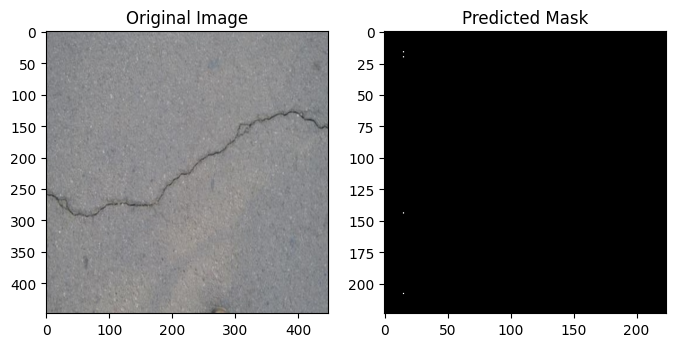

In [62]:
import matplotlib.pyplot as plt

original_image = cv2.imread('crack_segmentation_dataset\images\CFD_018.jpg')  # Replace with the actual path to your image

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')  # Assuming a single-channel mask
plt.title('Predicted Mask')

plt.show()